In [1]:
import polars as pl
# No an dependency. This is another package I developed
import polars_ds as pds 
import numpy as np
import pocache
import logging
logging.basicConfig(level=logging.INFO)


In [2]:
df = pds.frame(size = 300_000).with_columns(
    a = pds.random()
    , b = pds.random()
    , c = pds.random_str(min_size = 1, max_size = 3)
)
df.head()

row_num,a,b,c
i64,f64,f64,str
0,0.661332,0.260207,"""ZO"""
1,0.899758,0.403329,"""TEW"""
2,0.456415,0.23516,"""uIF"""
3,0.599156,0.578277,"""d"""
4,0.481051,0.765909,"""iA"""


# Example 1 - Cache in mem or cache in tempfile

In [3]:
ss_temp = pocache.Session(mode = "tempfile", verbose=True, secure=False)
ss_mem = pocache.Session(mode = "mem", verbose=True, secure=False)

In [4]:
@ss_mem.pocache
def expensive_df_transform1(df: pl.LazyFrame, threshold: float) -> pl.DataFrame:
    import time
    # Complicated stuff
    time.sleep(2)

    return df.lazy().filter(
        (pl.col("c").str.len_chars() == 1)
        & (pl.col("a") < threshold)
    ).with_columns(
        deciles = pl.col("a").qcut(10, labels = [f"decile_{str(i+1).zfill(3)}" for i in range(10)])
        , d = (pl.col("a") + pl.col("b")) / 2
    ).group_by("deciles").agg(
        pl.len().alias("cnt")
        , pl.col("a").min().alias("a_min")
        , pl.col("a").max().alias("a_max")
        , pl.col("d").std().alias("d_std")
        , pl.col("b").sum().alias("b_sum")
        , pl.col("c").n_unique().alias("c_n_unique")
    ).sort("deciles").collect()

In [5]:
@ss_temp.pocache(
    serializer = lambda df, path: df.write_parquet(path)
    , deserializer = lambda path: pl.read_parquet(path)
)
def expensive_df_transform2(df: pl.LazyFrame, threshold: float) -> pl.DataFrame:
    import time
    # Complicated stuff
    time.sleep(2)

    return df.lazy().filter(
        (pl.col("c").str.len_chars() == 1)
        & (pl.col("a") < threshold)
    ).with_columns(
        deciles = pl.col("a").qcut(10, labels = [f"decile_{str(i+1).zfill(3)}" for i in range(10)])
        , d = (pl.col("a") + pl.col("b")) / 2
    ).group_by("deciles").agg(
        pl.len().alias("cnt")
        , pl.col("a").min().alias("a_min")
        , pl.col("a").max().alias("a_max")
        , pl.col("d").std().alias("d_std")
        , pl.col("b").sum().alias("b_sum")
        , pl.col("c").n_unique().alias("c_n_unique")
    ).sort("deciles").collect()

In [6]:
expensive_df_transform1(df, threshold=0.8)

INFO:pocache:Hashing took: 0.002209s. The function took: 2.007042s. Saving cache took: 0.000004s.


deciles,cnt,a_min,a_max,d_std,b_sum,c_n_unique
cat,u32,f64,f64,f64,f64,u32
"""decile_001""",7985,0.000007,0.079655,0.144133,3991.432025,62
"""decile_002""",7985,0.079678,0.159418,0.142704,3976.596903,62
"""decile_003""",7985,0.159442,0.240975,0.14433,3997.607381,62
"""decile_004""",7985,0.24099,0.32118,0.145156,3957.724741,62
"""decile_005""",7985,0.321184,0.400707,0.14486,3952.138356,62
"""decile_006""",7985,0.400728,0.481038,0.144787,4006.778455,62
"""decile_007""",7985,0.481078,0.561656,0.144662,4000.135699,62
"""decile_008""",7985,0.561669,0.641113,0.144606,3955.186141,62
"""decile_009""",7985,0.641125,0.721491,0.144933,4003.495716,62


In [7]:
expensive_df_transform1(df, threshold = 0.8)

INFO:pocache:Cache hit. Hashing took: 0.001301s. Retrieval took: 0.000004s.


deciles,cnt,a_min,a_max,d_std,b_sum,c_n_unique
cat,u32,f64,f64,f64,f64,u32
"""decile_001""",7985,0.000007,0.079655,0.144133,3991.432025,62
"""decile_002""",7985,0.079678,0.159418,0.142704,3976.596903,62
"""decile_003""",7985,0.159442,0.240975,0.14433,3997.607381,62
"""decile_004""",7985,0.24099,0.32118,0.145156,3957.724741,62
"""decile_005""",7985,0.321184,0.400707,0.14486,3952.138356,62
"""decile_006""",7985,0.400728,0.481038,0.144787,4006.778455,62
"""decile_007""",7985,0.481078,0.561656,0.144662,4000.135699,62
"""decile_008""",7985,0.561669,0.641113,0.144606,3955.186141,62
"""decile_009""",7985,0.641125,0.721491,0.144933,4003.495716,62


In [8]:
expensive_df_transform2(df, threshold = 0.8)

INFO:pocache:Hashing took: 0.001381s. The function took: 2.006250s. Saving cache took: 0.003217s.


deciles,cnt,a_min,a_max,d_std,b_sum,c_n_unique
cat,u32,f64,f64,f64,f64,u32
"""decile_001""",7985,0.000007,0.079655,0.144133,3991.432025,62
"""decile_002""",7985,0.079678,0.159418,0.142704,3976.596903,62
"""decile_003""",7985,0.159442,0.240975,0.14433,3997.607381,62
"""decile_004""",7985,0.24099,0.32118,0.145156,3957.724741,62
"""decile_005""",7985,0.321184,0.400707,0.14486,3952.138356,62
"""decile_006""",7985,0.400728,0.481038,0.144787,4006.778455,62
"""decile_007""",7985,0.481078,0.561656,0.144662,4000.135699,62
"""decile_008""",7985,0.561669,0.641113,0.144606,3955.186141,62
"""decile_009""",7985,0.641125,0.721491,0.144933,4003.495716,62


In [9]:
expensive_df_transform2(df, threshold = 0.8)

INFO:pocache:Cache hit. Hashing took: 0.001488s. Retrieval took: 0.000986s.


deciles,cnt,a_min,a_max,d_std,b_sum,c_n_unique
cat,u32,f64,f64,f64,f64,u32
"""decile_001""",7985,0.000007,0.079655,0.144133,3991.432025,62
"""decile_002""",7985,0.079678,0.159418,0.142704,3976.596903,62
"""decile_003""",7985,0.159442,0.240975,0.14433,3997.607381,62
"""decile_004""",7985,0.24099,0.32118,0.145156,3957.724741,62
"""decile_005""",7985,0.321184,0.400707,0.14486,3952.138356,62
"""decile_006""",7985,0.400728,0.481038,0.144787,4006.778455,62
"""decile_007""",7985,0.481078,0.561656,0.144662,4000.135699,62
"""decile_008""",7985,0.561669,0.641113,0.144606,3955.186141,62
"""decile_009""",7985,0.641125,0.721491,0.144933,4003.495716,62


In [10]:
del ss_temp
del ss_mem

# Example 2 - Plotting

In [11]:
import altair as alt
alt.renderers.enable("svg")

import polars as pl
# No an dependency. This is another package I developed
import polars_ds as pds 
import pocache
import logging
logging.basicConfig(level=logging.INFO)

ss = pocache.Session(mode = "mem", verbose=True, secure=False)

In [12]:
df = pds.frame(size = 5_000).with_columns(
    a = pds.random()
    , b = pds.random()
).with_columns(
    category = pl.when(pl.col('a') < 0.5).then(pl.lit('category_1')).otherwise(pl.lit('category_2'))
)
df.head()

row_num,a,b,category
i64,f64,f64,str
0,0.058752,0.491303,"""category_1"""
1,0.086411,0.908987,"""category_1"""
2,0.282067,0.534249,"""category_1"""
3,0.070001,0.794047,"""category_1"""
4,0.353831,0.237329,"""category_1"""


In [13]:
@ss.pocache
def complicated_plotting(df, tooltip:list) -> alt.Chart:
    import time
    # Complicated stuff
    time.sleep(2)

    return alt.Chart(df).mark_circle(size=60).encode(
        x='a',
        y='b',
        color='category',
        tooltip=tooltip
    ).interactive()

INFO:pocache:Hashing took: 0.000583s. The function took: 2.007831s. Saving cache took: 0.000002s.


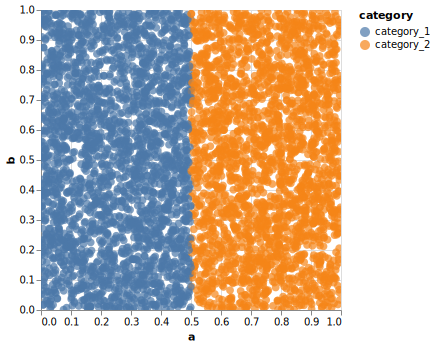

In [14]:
complicated_plotting(df, tooltip = ["row_num"])

INFO:pocache:Cache hit. Hashing took: 0.000595s. Retrieval took: 0.000002s.


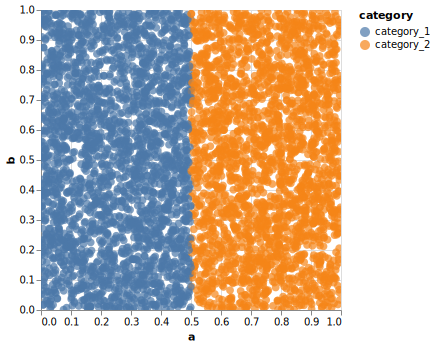

In [15]:
complicated_plotting(df, tooltip = ["row_num"])